# Import libraries and data

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from matplotlib_venn import venn2, venn3
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.multitest import multipletests

from utils import increase_stringency_CSF, print_p_val, preprocess

In [2]:
data_path = os.getcwd() + "/Datasets/"
fig_path = os.getcwd() + "/Figures/"

## Feature data set

In [3]:
brain_elevated = pd.read_csv(data_path + "/Features/df_features_brain_elevated_MS_filtered.csv")
print("Number of proteins in brain elevated feature data set:", len(brain_elevated))

Number of proteins in brain elevated feature data set: 2079


In [4]:
# drop non-sequence-based features
brain_elevated.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

In [5]:
col_dict = {"Disorder_NSP":"Disorder", 
            "Helix_NSP":"Helix", 
            "Coil_NSP":"Coil",
            "Sheet_NSP":"Sheet",
            "ExpAA":"TM residues", 
            "First60ExpAA":"First 60 TM residues", 
            "PredHel":"TM region",
            "PredHel_binary":"TM region (binary)",
            "Cell_membrane":"Cell membrane", 
            "Endoplasmic_reticulum":"Endoplasmic reticulum", 
            "Mitochondrion":"Mitochondrion",
            "Golgi_apparatus":"Golgi apparatus",                          
            "NetNGlyc":"N-linked Glycosylation (NetNGlyc)",
            "GlycoMine_N":"N-linked Glycosylation (GlycoMine)", 
            "GlycoMine_O":"O-linked Glycosylation (GlycoMine)", 
            "GlycoMine_C":"C-linked Glycosylation (GlycoMine)",
            "PS00022":"EGF1",
            "PS01186":"EGF2",
            "PS00232":"Cadherin-1",
            "PS00237":"G-protein receptor F1",
            "PS00027":"Homeobox",
            "PS00028":"Zinc Finger C2H2"}

# df_features.rename(columns=col_dict, inplace=True)

### Human Proteome

In [6]:
# all human proteins
df_human_proteome = pd.read_csv(data_path + "/Features/df_features.csv")
df_human_proteome.drop(["RNA_binding", "DNA_binding", "Ectodomain_shedding", "EV"], axis=1, inplace=True)

## CSF data set

In [7]:
csf = pd.read_csv(data_path + "CSF/csf.csv")
csf_3 = csf[csf["#Studies"] >= 3]

# Remove AD biomarkers

In [8]:
# create dictionary of known AD biomarkers
biomarker_dict = {"P05067": "APP", 
                  "P10636": "MAPT", 
                  "P07196": "NfL",
                  "P62760": "VLP-1", 
                  "P05413": "HFABP",
                  "P36222": "YKL-40", 
                  "P14136": "GFAP", 
                  "Q92686": "Neurogranin", 
                  "P21579": "Synaptotagmin",
                  "P60880": "SNAP25",
                  "P17677": "Neuromodulin/GAP43",
                  "P47972": "NPTX2",
                  "P56817": "BACE1", 
                  "P02778": "IP-10",                   
                  "Q9NZC2": "TREM2",
                  "Q7L0J3": "SV2A", 
                  "P30536": "TSPO"
                  }

print("Number of AD biomarker proteins to exclude:", len(biomarker_dict))

Number of AD biomarker proteins to exclude: 17


In [9]:
brain_elevated[brain_elevated["Uniprot"].isin(biomarker_dict.keys())]

,Uniprot,Sequence,Length,Molecular weight,A,C,D,E,F,G,...,PredHel,PredHel_binary,GPI-anchor,PS00022,PS01186,PS00232,PS00237,PS00028,PS00027,CSF
39,P56817,MAQALPWLLLWMGAGVLPAHGTQHGIRLPLRSGLGGAPLGLRLPRE...,501,55763.1514,0.067864,0.021956,0.053892,0.055888,0.043912,0.085828,...,1.0,1,0,0,0,0,0,0,0,1
368,Q92686,MDCCTENACSKPDDDILDIPLDDPGANAAAAKIQASFRGHMARKKI...,78,7618.3981,0.141026,0.038462,0.102564,0.025641,0.012821,0.217949,...,0.0,0,0,0,0,0,0,0,0,1
594,P36222,MGVKASQTGFVVLVLLQCCSAYKLVCYYTSWSQYREGDGSCFPDAL...,383,42624.9569,0.078329,0.018277,0.065274,0.026110,0.057441,0.088773,...,0.0,0,0,0,0,0,0,0,0,1
761,P14136,MERRRITSAARRSYVSSGEMMVGGLAPGRRLGPGTRLSLARMPPPL...,432,49879.6234,0.108796,0.002315,0.048611,0.138889,0.016204,0.030093,...,0.0,0,0,0,0,0,0,0,0,1
1344,P21579,MVSESHHEALAAPPVTTVATVLPSNATEPASPGEGKEDAFSKLKEK...,422,47572.5391,0.063981,0.014218,0.061611,0.082938,0.045024,0.059242,...,1.0,1,0,0,0,0,0,0,0,1
1461,P17677,MLCCMRRTKQVEKNDDDQKIEQDGIKPEDKAHKAATKIQASFRGHI...,238,24802.3764,0.197479,0.008403,0.075630,0.155462,0.004202,0.058824,...,0.0,0,0,0,0,0,0,0,0,1
1599,P47972,MLALLAASVALAVAAGAQDSPAPGSRFVCTALPPEAVHAGCPLPAM...,431,47040.9905,0.097448,0.016241,0.041763,0.081206,0.027842,0.088167,...,0.0,0,0,0,0,0,0,0,0,1
1629,Q7L0J3,MEEGFRDRAAFIRGAKDIAKEVKKHAAKKVVKGLDRVQDEYSRRSY...,742,82694.3729,0.075472,0.018868,0.047170,0.068733,0.078167,0.103774,...,12.0,1,0,0,0,0,0,0,0,1
1634,P60880,MAEDADMRNELEEMQRRADQLADESLESTRRMLQLVEESKDAGIRT...,206,23314.8715,0.077670,0.019417,0.092233,0.116505,0.009709,0.067961,...,0.0,0,0,0,0,0,0,0,0,1
1739,P62760,MGKQNSKLAPEVMEDLVKSTEFNEHELKQWYKGFLKDCPSGRLNLE...,191,22142.0948,0.047120,0.015707,0.089005,0.083770,0.073298,0.057592,...,0.0,0,0,0,0,0,0,0,0,1


In [10]:
set(biomarker_dict.keys())

{'P02778',
 'P05067',
 'P05413',
 'P07196',
 'P10636',
 'P14136',
 'P17677',
 'P21579',
 'P30536',
 'P36222',
 'P47972',
 'P56817',
 'P60880',
 'P62760',
 'Q7L0J3',
 'Q92686',
 'Q9NZC2'}

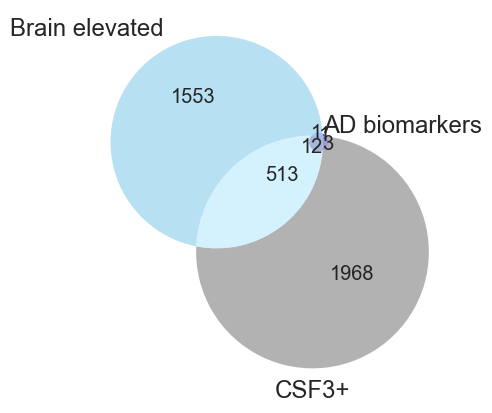

In [11]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 1, figsize=(7,5))

names = ["Brain elevated", "AD biomarkers", "CSF3+"]
colors = ("skyblue", "navy", "grey")

venn3([set(brain_elevated["Uniprot"]), set(biomarker_dict.keys()), set(csf_3["Uniprot"])], names, set_colors=colors, alpha=0.6)

plt.show()

In [12]:
brain_elevated_no_AD_biomarker = brain_elevated[~brain_elevated["Uniprot"].isin(biomarker_dict.keys())]
print("Number of proteins in feature data set:", len(brain_elevated_no_AD_biomarker))

Number of proteins in feature data set: 2066


# Machine Learning

In [13]:
# define variables and target
X = brain_elevated_no_AD_biomarker.drop(["Uniprot", "Sequence", "CSF"], axis=1)
y = brain_elevated_no_AD_biomarker["CSF"]

In [14]:
print("Number of features:", len(X.columns))

Number of features: 55


## Logistic classifier training

In [15]:
X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y)

In [16]:
def accuracy_stringent(df, n, model, save_model=True):
    """
    """
    
    # define explanatory and response variables
    X = (df.drop(["Uniprot", "Sequence", "CSF"], axis=1))
    y = (df["CSF"])
    
    bac = []
    auc = []
    coefs = []
    
    for i in range(10):
        
        X_train_bal, X_test_scal, y_train_bal, y_test, scaler = preprocess(X, y, random_state=i)
        
        # train model
        if model == "LogisticClassifier_L1":
            clf = LogisticRegression(penalty="l1", solver="saga", C=0.1, max_iter=10000, dual=False, 
                random_state=0).fit(X_train_bal, y_train_bal)
        elif model == "LogisticClassifier_L2":
            clf = LogisticRegression(penalty="l2", C=0.5, max_iter=1000, dual=False, 
                random_state=0).fit(X_train_bal, y_train_bal)     
            
        y_pred = clf.predict(X_test_scal)
        
        bac.append(balanced_accuracy_score(y_test, y_pred))
        auc.append(roc_auc_score(y_test, clf.decision_function(X_test_scal)))
        
        # extract coefficients
        coef = pd.Series(index=X_train_bal.columns, data=clf.coef_[0], name=i)
        coef.sort_values(ascending=False, key=abs, inplace=True)
        coefs.append(coef)
        
    coef_final_model = pd.Series(index=X_train_bal.columns, data=clf.coef_[0], name=n)
    coef_final_model.sort_values(ascending=False, key=abs, inplace=True)
    
    # merge all coefficient series into one dataframe
    coefs_df = pd.merge(coefs[0], coefs[1], left_index=True, right_index=True)
    for i in range(2, len(coefs)):
        coefs_df = pd.merge(coefs_df, coefs[i], left_index=True, right_index=True)  
    coefs_df["Mean"] = coefs_df.mean(axis=1)
    coefs_df["Standard deviation"] = coefs_df.std(axis=1)
    
    if (save_model == True) & (n in [1,2,3]):
        with open(os.getcwd() + "/Models/" + model + "_" + str(n) + "plus_no_AD_biomarker.pkl", "wb") as f:  
                pickle.dump(clf, f)

    return bac, auc, coefs_df, coef_final_model


def calculate_adjusted_p(scores):
    
    p_val_list = []
    
    for i in range(len(scores)-1):
        _, p = ttest_ind(scores[i], scores[i+1])
        p_val_list.append(p)
    
    adjusted_p = multipletests(p_val_list, alpha=0.05, method="fdr_bh")[1]
    
    return adjusted_p


def create_feature_coef_df(coef_df, col_dict, n, feature_num="all"):
    print("Number of features:", len(coef_df[n-1][coef_df[n-1] != 0]))
    if feature_num == "all":
        coefs = pd.DataFrame(coef_df[n-1])
    else:
        coefs = pd.DataFrame(coef_df[n-1][:feature_num])
    coefs.rename(index=col_dict, inplace=True)
    list_index = list(coefs.index)   
    
    return coefs, list_index

In [17]:
baclist_csf_l2 = []
auclist_csf_l2 = []
coefs_l2 = []
coef_final_model_l2 = []

print("Number of non-CSF proteins:", len(brain_elevated_no_AD_biomarker[brain_elevated_no_AD_biomarker["CSF"] == -1]))

for i in range(1, csf["#Studies"].max()+1):
    print("-------------")
    print("Number of minimum CSF studies:", i)
    df_stringent = increase_stringency_CSF(brain_elevated_no_AD_biomarker, csf, i)
    bac, auc, coef, coef_final_model  = accuracy_stringent(df_stringent, n=i, model="LogisticClassifier_L2")

    baclist_csf_l2.append(bac)
    auclist_csf_l2.append(auc)
    coef_final_model_l2.append(coef_final_model)

Number of non-CSF proteins: 1187
-------------
Number of minimum CSF studies: 1
Number of CSF proteins to be removed: 0
Number of CSF proteins left: 879
-------------
Number of minimum CSF studies: 2
Number of CSF proteins to be removed: 242
Number of CSF proteins left: 637
-------------
Number of minimum CSF studies: 3
Number of CSF proteins to be removed: 366
Number of CSF proteins left: 513
-------------
Number of minimum CSF studies: 4
Number of CSF proteins to be removed: 429
Number of CSF proteins left: 450
-------------
Number of minimum CSF studies: 5
Number of CSF proteins to be removed: 497
Number of CSF proteins left: 382
-------------
Number of minimum CSF studies: 6
Number of CSF proteins to be removed: 615
Number of CSF proteins left: 264


In [18]:
# calculate adjusted p-values
adjusted_p_l2_bac = calculate_adjusted_p(baclist_csf_l2)
adjusted_p_l2_auc = calculate_adjusted_p(auclist_csf_l2)

In [19]:
for i in range(6): 
    print("Minimum study criterion:", i+1)
    print("Average balanced accuracy: %.02f" % [np.mean(i)*100 for i in baclist_csf_l2][i])
    print("Standard deviation: %.02f" % [np.std(i)*100 for i in baclist_csf_l2][i])
    if i > 0:
        print("Adjusted P-value: %.04f" % adjusted_p_l2_bac[i-1])
    print("------------------")

Minimum study criterion: 1
Average balanced accuracy: 73.38
Standard deviation: 2.25
------------------
Minimum study criterion: 2
Average balanced accuracy: 78.95
Standard deviation: 2.08
Adjusted P-value: 0.0002
------------------
Minimum study criterion: 3
Average balanced accuracy: 82.16
Standard deviation: 1.28
Adjusted P-value: 0.0024
------------------
Minimum study criterion: 4
Average balanced accuracy: 82.59
Standard deviation: 1.52
Adjusted P-value: 0.5345
------------------
Minimum study criterion: 5
Average balanced accuracy: 83.17
Standard deviation: 2.25
Adjusted P-value: 0.5345
------------------
Minimum study criterion: 6
Average balanced accuracy: 84.40
Standard deviation: 3.88
Adjusted P-value: 0.5345
------------------


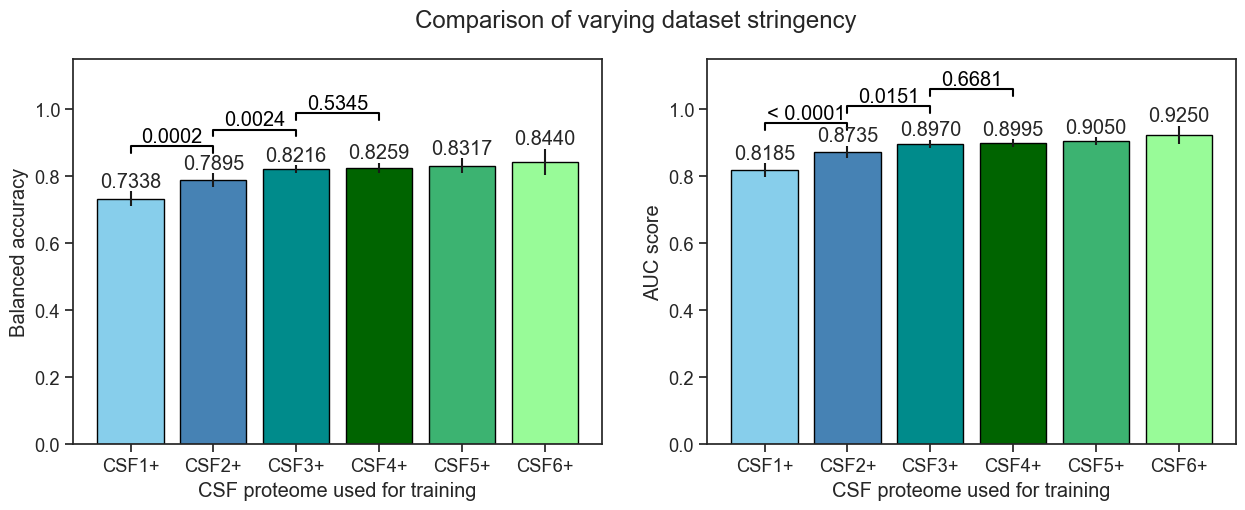

In [20]:
sns.set(style=("ticks"), font_scale=1.2)
fig, ax = plt.subplots(1, 2, figsize=(15,5))

bars = ax[0].bar(x=["CSF1+","CSF2+","CSF3+","CSF4+","CSF5+","CSF6+"], height=[np.mean(i) for i in baclist_csf_l2],
    yerr=[np.std(i) for i in baclist_csf_l2], color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", 
    "palegreen", "yellowgreen"], edgecolor="black")
ax[0].bar_label(bars, fmt="%.4f")
ax[0].set(xlabel="CSF proteome used for training", ylabel="Balanced accuracy", ylim=(0, 1.15))

# add p-value annotations
r, h = 0.87, 0.02
ax[0].plot([0, 0, 1, 1], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(0.5, r+0.02, print_p_val(adjusted_p_l2_bac[0]), ha="center", va="bottom", color="black")
r, h = 0.92, 0.02
ax[0].plot([1, 1, 2, 2], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(1.5, r+0.02, print_p_val(adjusted_p_l2_bac[1]), ha="center", va="bottom", color="black")
r, h = 0.97, 0.02
ax[0].plot([2, 2, 3, 3], [r, r+h, r+h, r], lw=1.5, color="black")
ax[0].text(2.5, r+0.02, print_p_val(adjusted_p_l2_bac[2]), ha="center", va="bottom", color="black")

bars = ax[1].bar(x=["CSF1+","CSF2+","CSF3+","CSF4+","CSF5+","CSF6+"], height=[np.mean(i) for i in auclist_csf_l2], 
    yerr=[np.std(i) for i in auclist_csf_l2], color=["skyblue", "steelblue", "darkcyan", "darkgreen", "mediumseagreen", 
    "palegreen", "yellowgreen"], edgecolor="black")
ax[1].bar_label(bars, fmt="%.4f")
ax[1].set(xlabel="CSF proteome used for training", ylabel="AUC score", ylim=(0, 1.15))

# add p-value annotations
r, h = 0.94, 0.02
ax[1].plot([0, 0, 1, 1], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(0.5, r+0.02, print_p_val(adjusted_p_l2_auc[0]), ha="center", va="bottom", color="black")
r, h = 0.99, 0.02
ax[1].plot([1, 1, 2, 2], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(1.5, r+0.02, print_p_val(adjusted_p_l2_auc[1]), ha="center", va="bottom", color="black")
r, h = 1.04, 0.02
ax[1].plot([2, 2, 3, 3], [r, r+h, r+h, r], lw=1.5, color="black")
ax[1].text(2.5, r+0.02, print_p_val(adjusted_p_l2_auc[2]), ha="center", va="bottom", color="black")

plt.suptitle("Comparison of varying dataset stringency")
plt.show()
# fig.savefig(fig_path + "Increased_dataset_stringency_CSF_L2.png", bbox_inches="tight", dpi=300, transparent=True)

## Prediction on AD biomarkers

In [21]:
# load model trained without AD biomarkers
with open(os.getcwd() + "/Models/LogisticClassifier_L2_3plus_no_AD_biomarker.pkl", "rb") as f:  
    L2_CSF3 = pickle.load(f)

In [22]:
# define variables and target
X = df_human_proteome.drop(["Uniprot", "Sequence", "CSF"], axis=1)

# define continuous variables
cont = ['Length', 'Molecular weight', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 
        'V', 'W', 'Y', 'Isoelectric point', 'Instability index', 'Solubility', 'Disorder_NSP', 'Helix_NSP', 'Coil_NSP', 
        'Sheet_NSP', 'ExpAA', 'First60ExpAA', 'PredHel']

# preprocess data with same scaler as training data
X_scal = X.copy()
X_scal[cont] = scaler.transform(X_scal[cont])

In [23]:
# predict on full human proteome
proba = L2_CSF3.predict_proba(X_scal)

# add probabilities to dataframe
proba_df = pd.DataFrame(proba, columns=["non_CSF", "CSF"])
df_human_proteome["Score"] = proba_df["CSF"]

# subset AD biomarkers
biomarkers_pred = df_human_proteome[df_human_proteome["Uniprot"].isin(biomarker_dict.keys())]
biomarkers_pred = biomarkers_pred.sort_values(by="Score", ascending=False)

In [24]:
for biomarker in biomarkers_pred["Uniprot"]:
    print(biomarker_dict[biomarker], "%.04f" \
    % df_human_proteome[df_human_proteome["Uniprot"] == biomarker]["Score"].values[0])

Neuromodulin/GAP43 0.9976
APP 0.9769
Neurogranin 0.9677
IP-10 0.9650
NPTX2 0.9617
Synaptotagmin 0.9487
YKL-40 0.9258
BACE1 0.9034
HFABP 0.8889
MAPT 0.7528
SNAP25 0.6132
TREM2 0.5322
NfL 0.3938
GFAP 0.3102
VLP-1 0.2686
SV2A 0.1130
TSPO 0.0446


In [25]:
# create dictionary of biomarker function
function_dict = {"P05067": "Abeta pathology", # APP
              "P10636": "Tau pathology", # MAPT
              "P07196": "Neuronal injury", # NfL
              "P62760": "Neuronal injury", # VLP-1
              "P05413": "Vascular dysregulation", # HFABP
              "P36222": "Inflammation", # YKL-40
              "P14136": "Neuronal injury", #GFAP
              "Q92686": "Synaptic dysfunction", # Neurogranin
              "P21579": "Synaptic dysfunction", # Synaptotagmin
              "P60880": "Synaptic dysfunction", # SNAP25
              "P17677": "Synaptic dysfunction", # Neuromodulin
              "P47972": "Synaptic dysfunction", # NPTX2
              "P56817": "Abeta pathology", # BACE1
              "P02778": "Inflammation", # IP-10                 
              "Q9NZC2": "Inflammation", # TREM2
              "Q7L0J3": "PET biomarker", # SV2A
              "P30536": "PET biomarker" # TSPO
              }
   
function_df = pd.DataFrame.from_dict(function_dict, orient="index").reset_index() 
function_df.columns = ["Uniprot", "Biomarker_category"]

# merge biomarker dataframe with function column
biomarkers_pred = biomarkers_pred.merge(function_df, on="Uniprot", how="inner")

In [26]:
# manually determine legend labels by sorting dataframe based on functioncategory
custom_dict = {"Abeta pathology": 0, "Tau pathology": 1, "Synaptic dysfunction": 2, "Inflammation": 3,
               "Vascular dysregulation": 4, "Neuronal injury": 5, "PET biomarker":6}

biomarkers_pred.sort_values(by=["Biomarker_category"], key=lambda x: x.map(custom_dict), inplace=True)

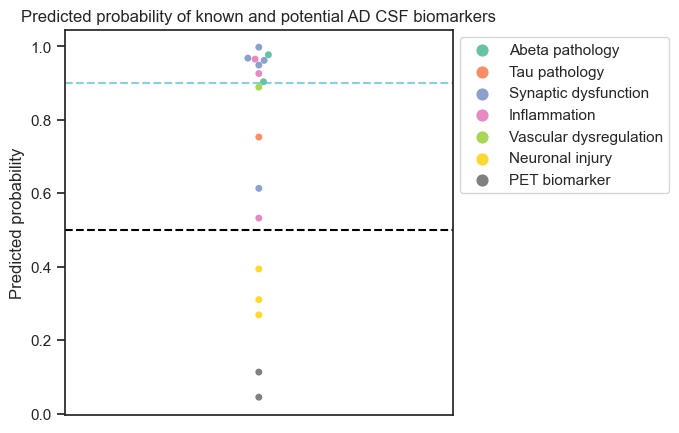

In [27]:
sns.set(style=("ticks"), font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(5,5))

sns.swarmplot(data=biomarkers_pred, x=[0]*len(biomarkers_pred), y="Score", hue="Biomarker_category",
             palette=sns.color_palette("Set2", 6) + ["grey"])
ax.set(title="Predicted probability of known and potential AD CSF biomarkers", ylabel="Predicted probability", xticks=[],
      xticklabels=[])
ax.axhline(0.5, color="black", linestyle="--")
ax.axhline(0.9, color="skyblue", linestyle="--")
ax.legend(bbox_to_anchor=(1,1)) 

plt.show()
fig.savefig(fig_path + "Probability_AD_CSF_biomarkers.png", bbox_inches="tight", dpi=300, transparent=True)